In [1]:
import os
from tqdm.notebook import tqdm
import pickle
import sys
from argparse import ArgumentParser
import logging
import time
import gc



import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils import data
from torch.nn import functional as fnn

import torchvision.models as models
from torchvision import transforms
import cv2

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(1234)
torch.manual_seed(1234)

TRAIN_SIZE = 0.8
NUM_PTS = 971
CROP_SIZE = 128
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"


In [3]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample


class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample


class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, transforms, names, landmarks, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.transforms = transforms
        self.image_names = names
        if split in ("train", "val"):
            self.landmarks = torch.as_tensor(landmarks)
        else:
            self.landmarks = None

    def __getitem__(self, idx):
        sample = {}
        if self.landmarks is not None:
            landmarks = self.landmarks[idx]
            sample["landmarks"] = landmarks

        image = cv2.imread(self.image_names[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.image_names)
    
# not correct work
#class ThousandLandmarksDataset_Fast(data.Dataset):
#    def __init__(self, transforms, names,  landmarks, split="train"):
#        super(ThousandLandmarksDataset_Fast, self).__init__()
#        
#        self.samples=[]
#        sample = {}
#        
#
#        if split in ("train", "val"):
#            landmarks = torch.as_tensor(landmarks)
#        else:
#            landmarks = None
#
#        if landmarks is not None:
#            for idx, name in tqdm(enumerate(names,start=0), desc="Prepare data..."):
#                image = cv2.imread(name)
#                sample["image"] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                landmark = landmarks[idx]
#                sample["landmarks"] = landmark
#                self.samples.append(transforms(sample))
#        else:
#            for name in tqdm(names,desc="Prepare data...") :
#                image = cv2.imread(name)
#                sample["image"] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                self.samples.append(transforms(sample))        
#
#    def __getitem__(self, idx):
#        return self.samples[idx]
#
#    def __len__(self):
#        return len(self.samples)


def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks


def create_submission(path_to_data, test_predictions, path_to_submission_file):
    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping = pd.read_csv(path_to_data, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')


In [4]:
def train_model(model, loaders, loss_fn, optimizer, scheduler, n_epochs, device, labelStr="model", show_plots=True):
    since = time.time()
    model.to(device)
    best_val_loss = np.inf    
    
    losses = {phase: [] for phase in ['train', 'val']}
    
    descBatch = {'train':"training...",'val':"validation..."}
    
    for epoch in tqdm(range(n_epochs), desc="epoch"):
        for phase in ['train', 'val']:            
            model.train() if phase == 'train' else model.eval()
            loss_history = []
            for batch in tqdm(loaders[phase], total=len(loaders[phase]), desc=descBatch[phase]):
                images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
                landmarks = batch["landmarks"]
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    pred_landmarks = model(images).cpu() 
                    loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
                    #loss = loss_fn(pred_landmarks, landmarks)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                loss_history.append(loss.item())
                
            if phase == 'train':
                scheduler.step(loss)
                #scheduler.step()
            losses[phase].append(np.mean(loss_history))
        
        # output info and save more success model
        if show_plots:
            clear_output(True)        
            for phase in ['train', 'val']:
                plt.plot(losses[phase], label=phase)
            plt.legend()
            plt.grid()
            plt.show()
            for i in range(len(losses['train'])):print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}\n".format(i, losses['train'][i], losses['val'][i]))
        else:
            print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}\n".format(i, losses['train'][-1], losses['val'][-1]))
        
        if losses['val'][-1] < best_val_loss:
            best_val_loss = losses['val'][-1] 
            filename = "{2}loss_{0}_epoch{1}".format(labelStr, epoch, losses['val'][-1])
            with open(f"{filename}.pth", "wb") as fp:
                torch.save(model.state_dict(), fp)
    
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_val_loss))

    return model

In [5]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions


INFO:\
ResNet18 (pretrained on ImageNet). Training takes ~ 15 mins. batch=512 (NVIDIA GTX1060 6GB)\
ResNet101 (pretrained on ImageNet). Training takes ~ x mins. batch=80 (NVIDIA GTX1060 6GB)\
ResNeXT50 (pretrained on ImageNet). Training takes ~ 36 mins  batch=112 (NVIDIA GTX1060 6GB)\
ResNeXT50 (pretrained on ImageNet). Training takes ~ 25 mins  batch=384 (NVIDIA T4 16GB)

**Config model**

In [6]:
# указать путь к конвертированным данным
#pathData=""
pathData = "C:\\Users\\Lisen\\Desktop\\CV\\CV_01\\data\\data\\prepare_data_10.0PERCENT\\"

#batch_size = 384
batch_size = 112
#epochs = 15
epochs = 7
learning_rate = 1e-3
gpu = True

device = torch.device("cuda: 0") if gpu else torch.device("cpu")

Augmentations (Now empty)

In [7]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

Read train data

In [8]:
#change num_workers from 4 to 0, because windows
X_train = np.load(os.path.join(pathData, "X_train.npy"))
names_train = open(os.path.join(pathData, "names_train"), "r").read().split('\n')[:-1]
train_dataloader = data.DataLoader(ThousandLandmarksDataset(train_transforms, names_train, X_train, split="train"),
                                       batch_size=batch_size,
                                       num_workers=0, pin_memory=True,
                                       shuffle=True, drop_last=True)
#change num_workers from 4 to 0, because windows
X_val = np.load(os.path.join(pathData, "X_val.npy"))
names_val = open(os.path.join(pathData, "names_val"), "r").read().split('\n')[:-1]
val_dataloader = data.DataLoader(ThousandLandmarksDataset(train_transforms, names_val, X_val, split="val"),
                                     batch_size=batch_size,
                                     num_workers=0, pin_memory=True,
                                     shuffle=False, drop_last=False)


**Stage 1**\
Create model, train model

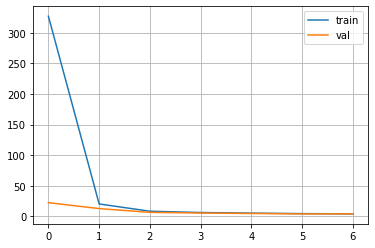

Epoch # 0:	train loss: 3.3e+02	val loss: 2.2e+01

Epoch # 1:	train loss: 2e+01	val loss: 1.3e+01

Epoch # 2:	train loss:   8.4	val loss:   6.6

Epoch # 3:	train loss:   6.3	val loss:   5.5

Epoch # 4:	train loss:   5.3	val loss:   4.8

Epoch # 5:	train loss:   4.5	val loss:   4.0

Epoch # 6:	train loss:   4.1	val loss:   4.2


Training complete in 34m 36s
Best val Acc: 4.040734


In [9]:
resnext50 = models.resnext50_32x4d(pretrained=True)
resnext50.fc = nn.Linear(resnext50.fc.in_features, 2 * NUM_PTS, bias=True)

loss_fn = fnn.mse_loss
optimizer = optim.Adam(resnext50.parameters(), lr=learning_rate, amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2)

resnext50 = train_model(resnext50,{"train":train_dataloader,"val":val_dataloader,},loss_fn,optimizer, scheduler,epochs,device, "resnext50__FirstStage",show_plots=True)
torch.cuda.empty_cache()

**Stage 2**\
Refresh learning rate, change  config scheduler

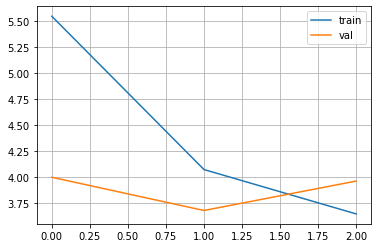

Epoch # 0:	train loss:   5.6	val loss:   4.0

Epoch # 1:	train loss:   4.1	val loss:   3.7

Epoch # 2:	train loss:   3.6	val loss:   4.0


Training complete in 14m 48s
Best val Acc: 3.675221


In [10]:
#epochs = 30
epochs = 3
learning_rate = 1e-3

# указать путь к лучшей модели или дообучать последнюю эпоху
pathModel = ""
if pathModel != "":
    del resnext50
    torch.cuda.empty_cache()
    gc.collect()
    resnext50 = models.resnext50_32x4d(pretrained=True)
    resnext50.fc = nn.Linear(model_pred.fc.in_features, 2 * NUM_PTS, bias=True)
    resnext50.to(device)
    with open(pathModel, "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        resnext50.load_state_dict(best_state_dict) 

loss_fn = fnn.mse_loss
optimizer = optim.Adam(resnext50.parameters(), lr=learning_rate, amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

resnext50 = train_model(resnext50,{"train":train_dataloader,"val":val_dataloader,},loss_fn,optimizer, scheduler,epochs,device, "resnext50_SecondStage",show_plots=True)
torch.cuda.empty_cache()

**Predict**

In [11]:
# указать путь к test_points.csv 
testPoints=""
#testPoints = "C:\\Users\\Lisen\\Desktop\\CV\\CV_01\\data\\data\\test\\test_points.csv"

# указать путь к лучшей модели или дообучать последнюю эпоху
pathModel = ""
if pathModel != "":
    del resnext50
    torch.cuda.empty_cache()
    gc.collect()
    resnext50 = models.resnext50_32x4d(pretrained=True)
    resnext50.fc = nn.Linear(model_pred.fc.in_features, 2 * NUM_PTS, bias=True)
    resnext50.to(device)
    with open(pathModel, "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        resnext50.load_state_dict(best_state_dict)
        



# load test
#change num_workers from 4 to 0, because windows
names_test = open(os.path.join(pathData, "names_test"), "r").read().split('\n')[:-1]
test_dataloader = data.DataLoader(ThousandLandmarksDataset(train_transforms, names_test, None, split="test"),
                                      batch_size=batch_size, num_workers=0, pin_memory=True,
                                      shuffle=False, drop_last=False)


test_predictions = predict(resnext50, test_dataloader, device)
create_submission(testPoints, test_predictions, "resnext50_submit.csv")

**Watch result**

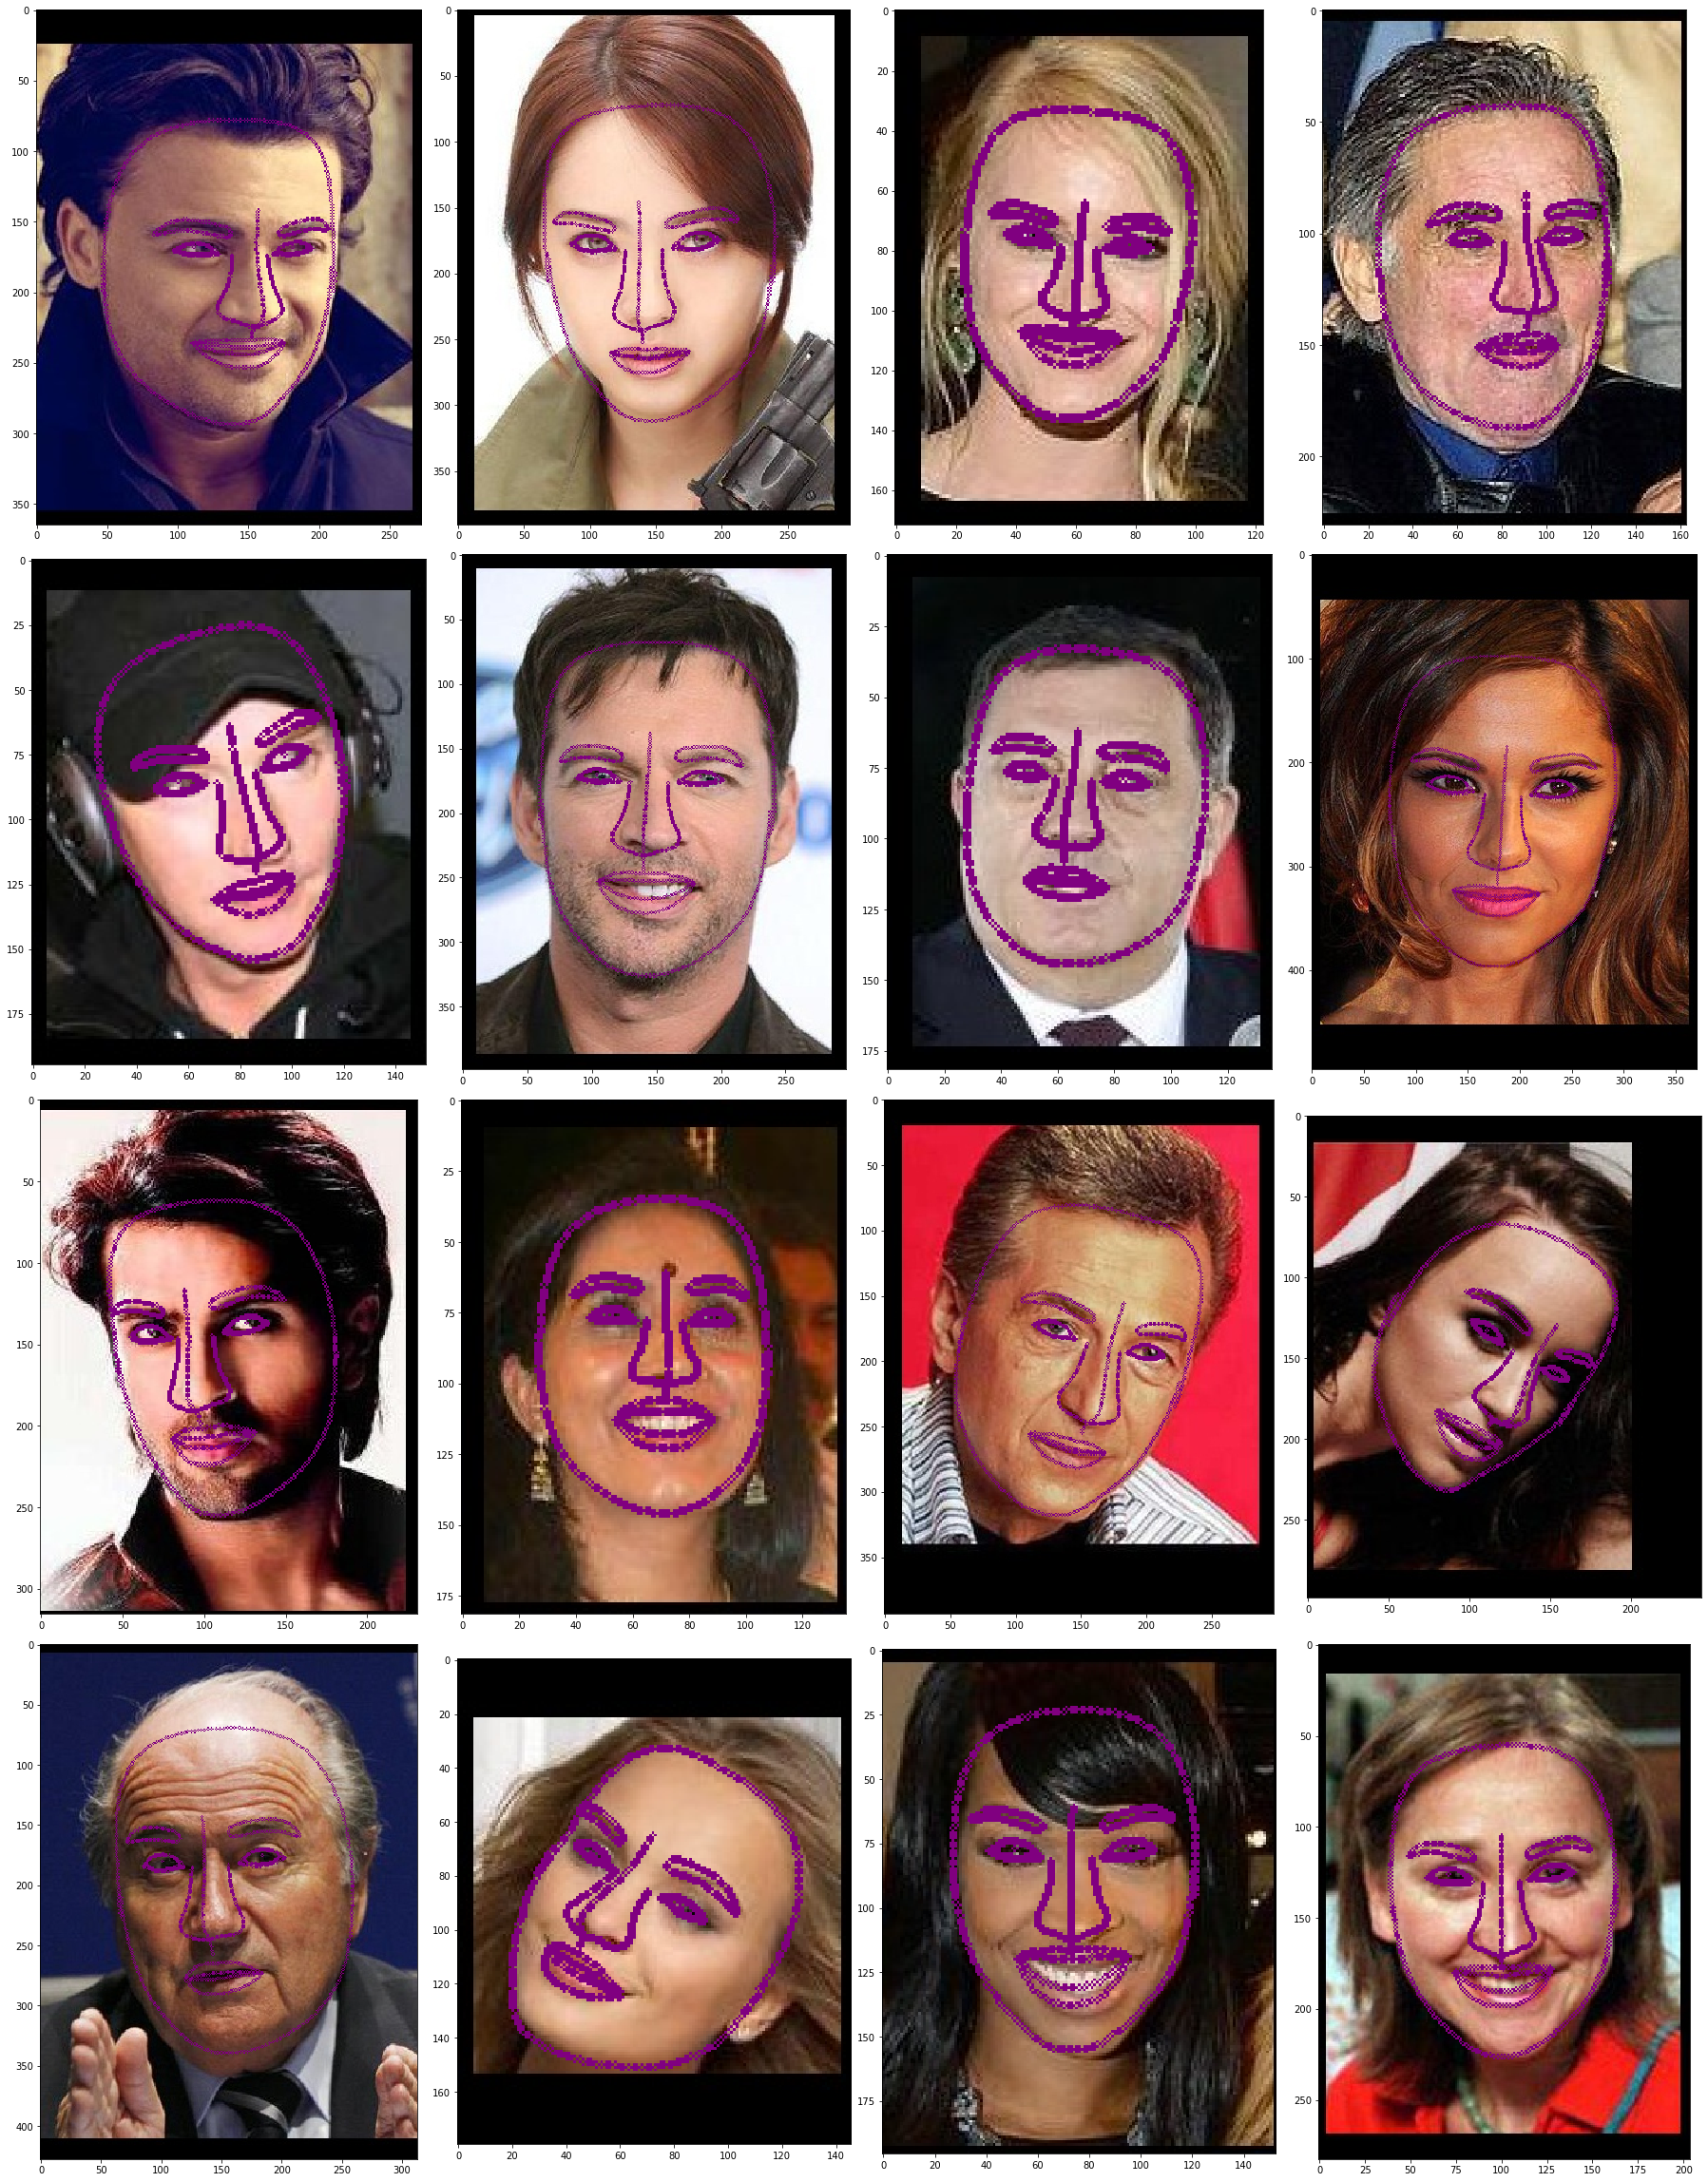

In [12]:
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

if len(names_test) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(names_test)}")
    
    
random_idxs = np.random.choice(len(names_test), size=min(NUM_IMAGES_TO_SHOW, len(names_test)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(names_test[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, test_predictions[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()